In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn import metrics
%matplotlib inline

In [2]:
df = pd.read_csv('Data/compresive_strength_concrete.csv')
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
for i in df.columns:
    df.rename(columns = {i:i.split('(')[0].strip()},inplace = True)

In [4]:
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [5]:
df.shape

(1030, 9)

In [6]:
df.isnull().sum()

Cement                           0
Blast Furnace Slag               0
Fly Ash                          0
Water                            0
Superplasticizer                 0
Coarse Aggregate                 0
Fine Aggregate                   0
Age                              0
Concrete compressive strength    0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
Blast Furnace Slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
Fly Ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
Water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
Superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
Coarse Aggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
Fine Aggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
Age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
Concrete compressive strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


## Exploratory Data Analysis

In [8]:
def outliers(data):
    dict_ = {}
    set_ = set()
    for feature in data.columns[:-1]:
        Q1 = data[feature].quantile(q=0.25)
        Q3 = data[feature].quantile(q=0.75)
        IQR = Q3 - Q1
        #print('Interquartile Range for feature '+ feature + ' is {:.2f}'.format(IQR))
        Lower_lim = Q1 - 1.5*IQR
        Upper_lim = Q3 + 1.5*IQR

        upper_out = data[data[feature]>Upper_lim].index.values
        lower_out = data[data[feature]<Lower_lim].index.values
        print(feature +' has {} upper and {} lower outliers'.format(len(upper_out),len(lower_out)))
        
        dict_[feature] = {}
        dict_[feature]['lower_out'] = lower_out
        dict_[feature]['upper_out'] = upper_out
            
    return dict_

In [9]:
outlier = outliers(df)

Cement has 0 upper and 0 lower outliers
Blast Furnace Slag has 2 upper and 0 lower outliers
Fly Ash has 0 upper and 0 lower outliers
Water has 4 upper and 5 lower outliers
Superplasticizer has 10 upper and 0 lower outliers
Coarse Aggregate has 0 upper and 0 lower outliers
Fine Aggregate has 5 upper and 0 lower outliers
Age has 59 upper and 0 lower outliers


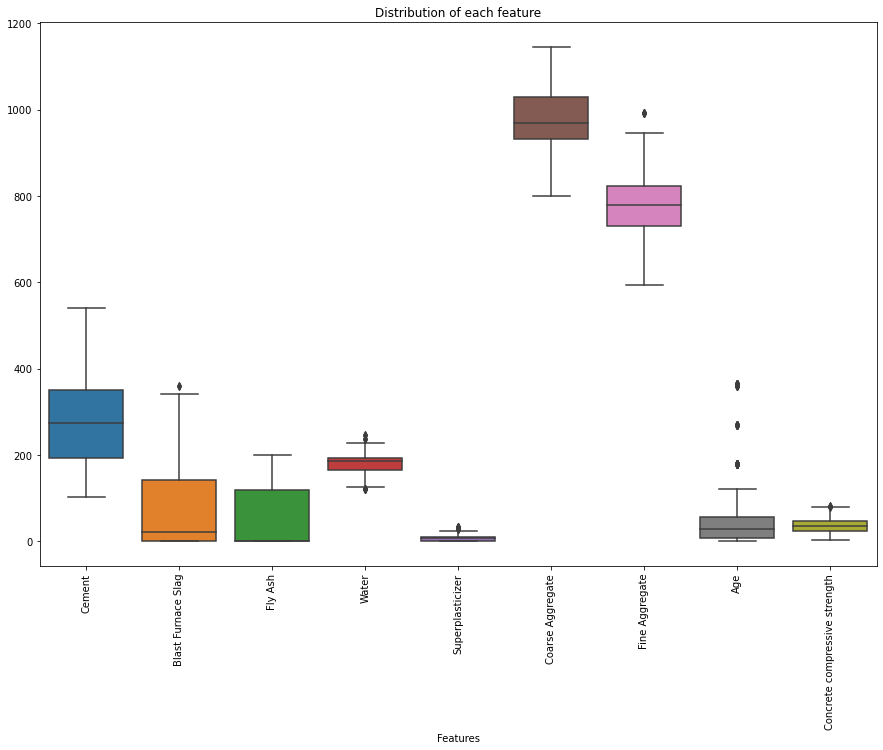

In [10]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Distribution of each feature')
plt.xlabel('Features')
plt.show()

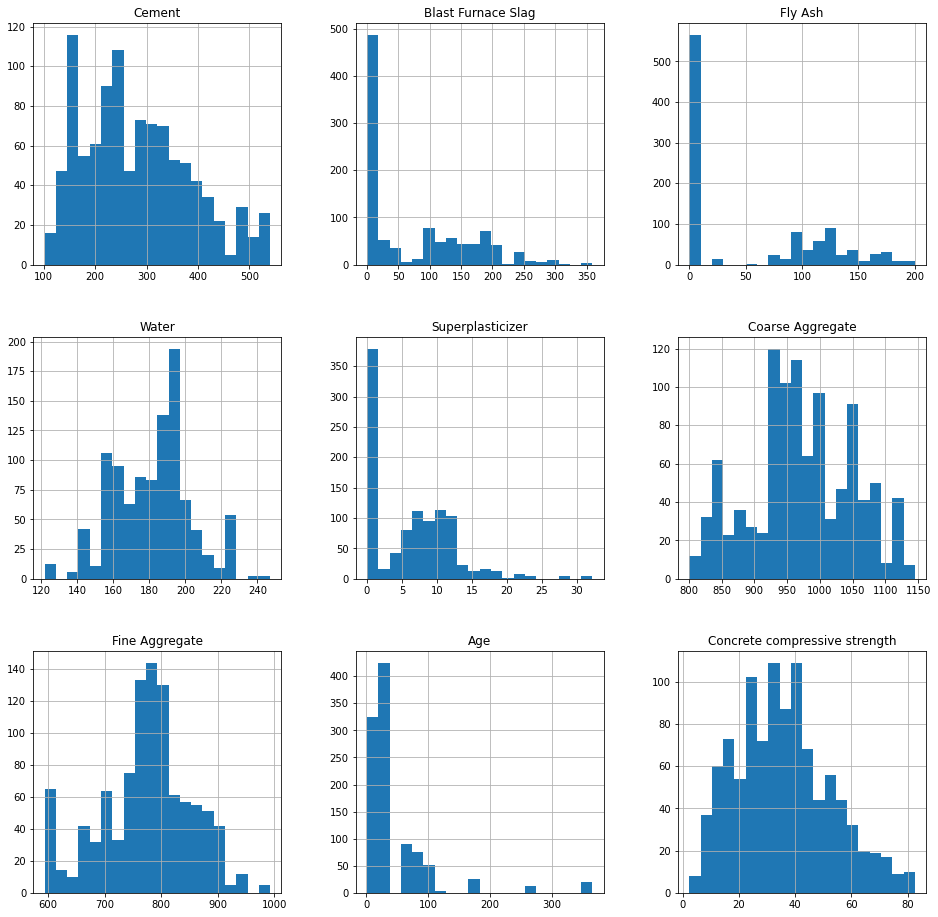

In [11]:
df.hist(figsize= (16,16),bins=20);

<Figure size 1440x1440 with 0 Axes>

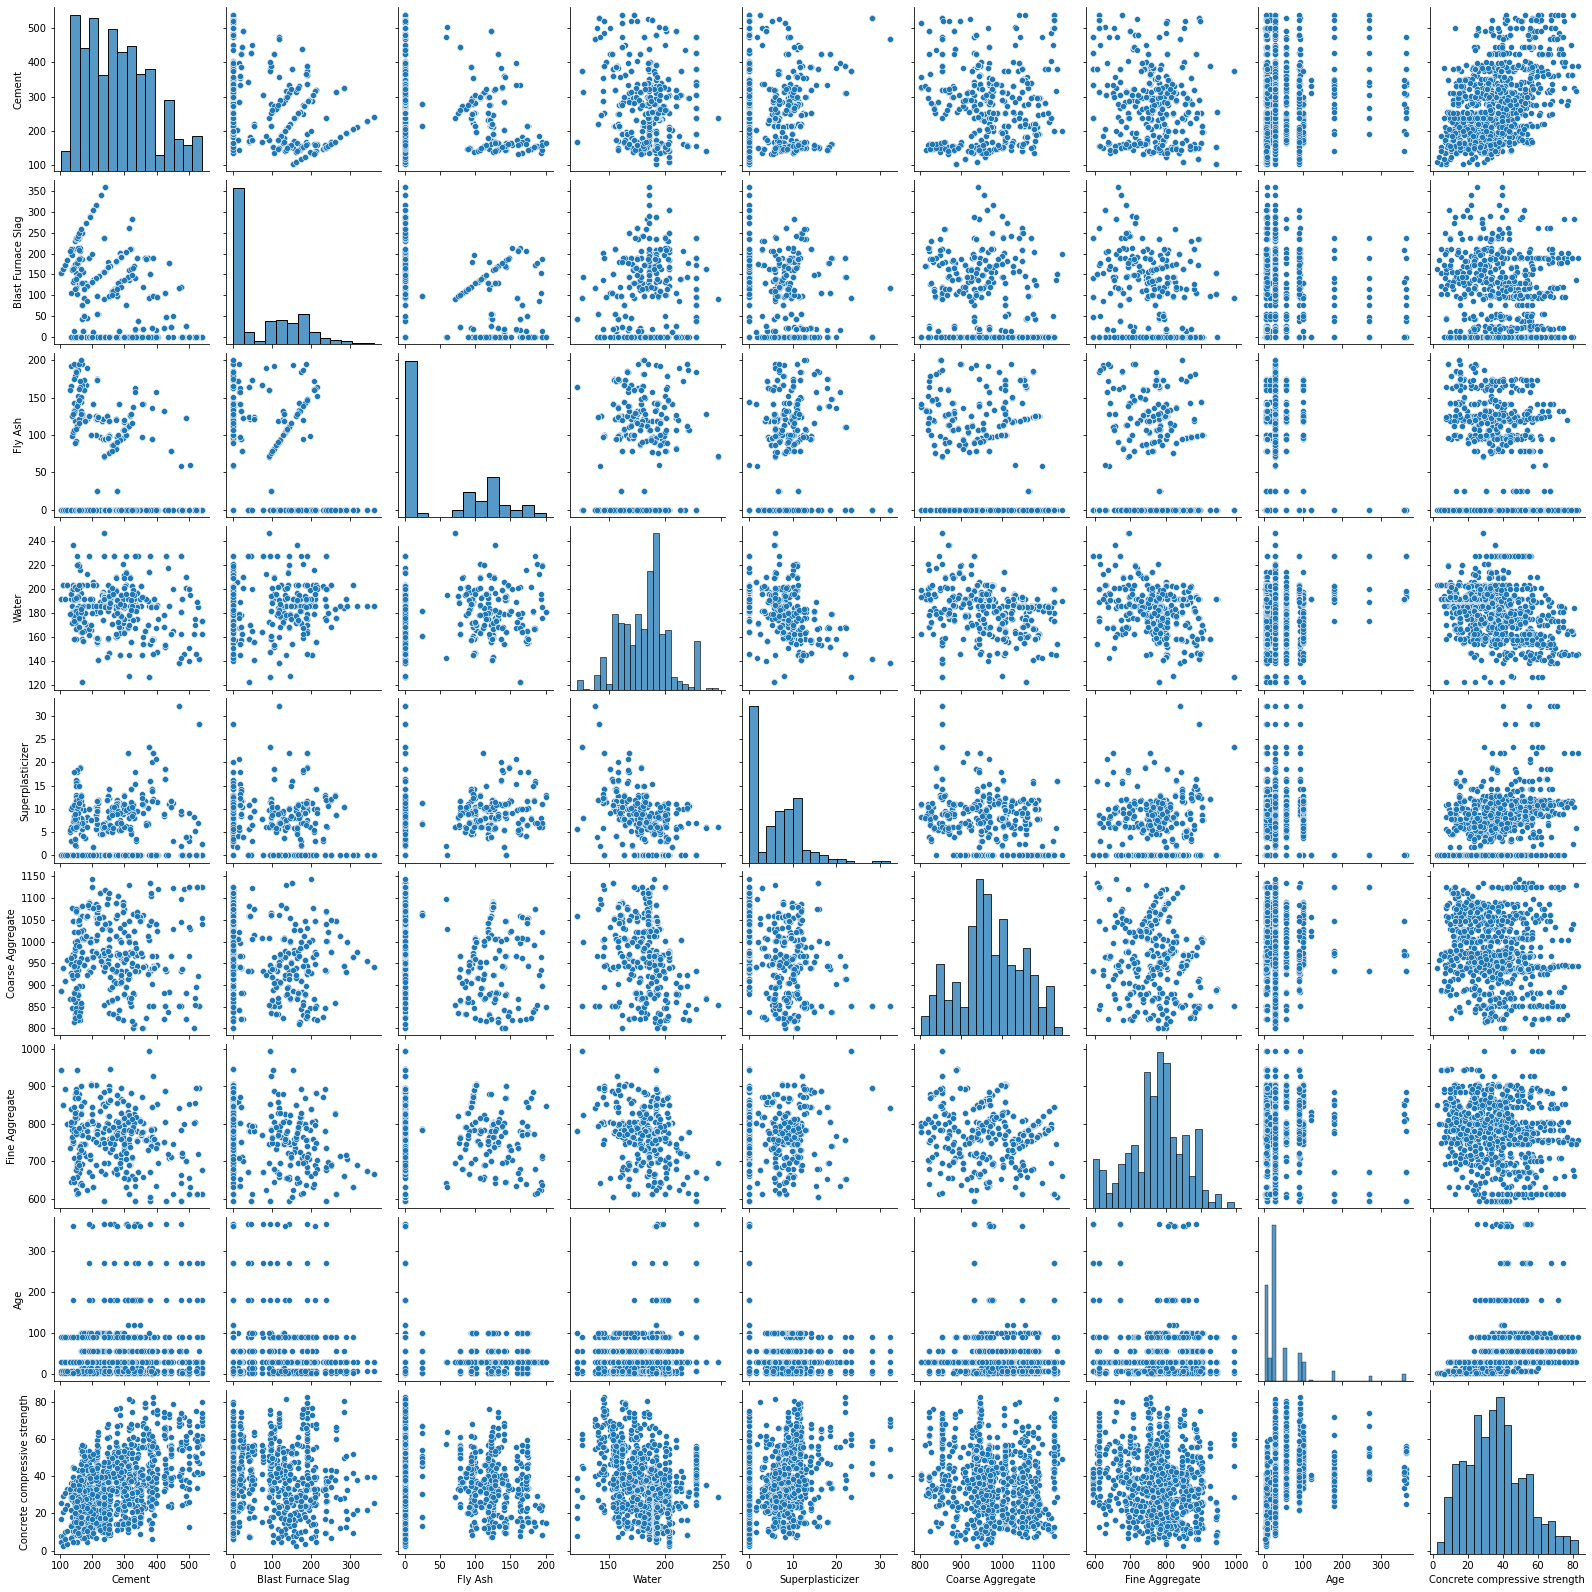

In [12]:
plt.figure(figsize = (20,20))
sns.pairplot(df);

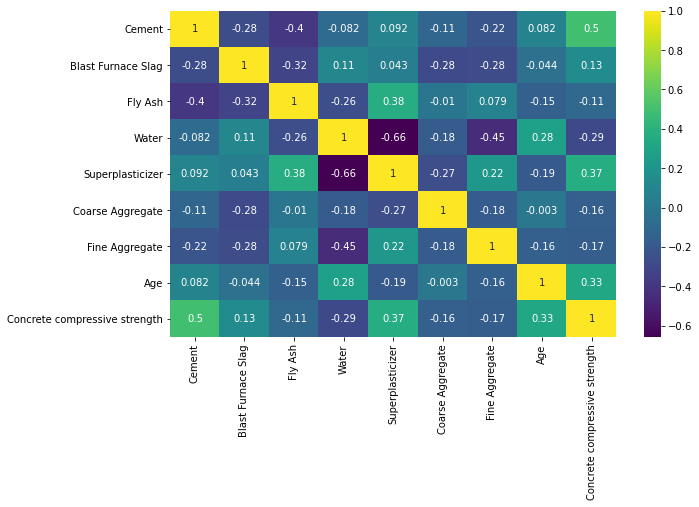

In [13]:
plt.figure(figsize = (10,6))
sns.heatmap(df.corr(),cmap='viridis', annot =True);

**Replacing Outliers**

In [14]:
for i in outlier.keys():
    for j in outlier[i].keys():
        if len(outlier[i][j]) == 0:
            continue
        else:
            for k in outlier[i][j]:
                df.loc[k,i] = df[i].median()

## Feature Engineering and Model Building

In [15]:
X = df.iloc[:,:-1]
y = df['Concrete compressive strength']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### RandomForestRegressor()

In [18]:
rfc = RandomForestRegressor()
rfc.fit(X_train,y_train)

RandomForestRegressor()

In [19]:
ypred_rfc = rfc.predict(X_test)

In [20]:
# Model Performance on Training Data
rfc.score(X_train,y_train)

0.9811881452351817

In [21]:
# Model Performance on Testing Data
rfc.score(X_test,y_test)

0.8756015402972351

In [22]:
acc_rfc = metrics.r2_score(y_test,ypred_rfc)
acc_rfc

0.8756015402972351

In [23]:
metrics.mean_squared_error(y_test,ypred_rfc)

32.60573183427503

In [24]:
results = {}
results['Algorithm'] = ['Random Forest']
results['Accuracy'] =  [acc_rfc]
results

{'Algorithm': ['Random Forest'], 'Accuracy': [0.8756015402972351]}

**KFold Cross Validation**

In [25]:
k = 20
kfold = KFold(n_splits=k)
K_result = cross_val_score(rfc, X, y, cv = kfold)
accuracy = np.mean(abs(K_result))
accuracy

0.7618504284665278

In [26]:
results['Algorithm'].append('Random Forest k-fold')
results['Accuracy'].append(accuracy)

### Gradient Boosting Regressor

In [27]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)

GradientBoostingRegressor()

In [28]:
# Model Performance on Training Data
gbr.score(X_train,y_train)

0.9477368610390589

In [29]:
# Model Performance on Testing Data
acc_g = gbr.score(X_test,y_test)
acc_g

0.8801126616920965

In [30]:
ypred_gbr = gbr.predict(X_test)
metrics.mean_squared_error(y_test,ypred_gbr)

31.423334441058433

In [31]:
results['Algorithm'].append('Gradient Boosting Regressor')
results['Accuracy'].append(acc_g)

**KFold Cross Validation**

In [32]:
k = 20
kfold = KFold(n_splits=k)
K_result = cross_val_score(gbr, X, y, cv = kfold)
accuracy = np.mean(abs(K_result))
accuracy

0.7685337663478469

In [33]:
results['Algorithm'].append('Gradient Boosting Regressor k-fold')
results['Accuracy'].append(accuracy)

### Ada Boosting Regressor

In [34]:
model = AdaBoostRegressor()
model.fit(X_train,y_train)

AdaBoostRegressor()

In [35]:
# Model Performance on Training Data
model.score(X_train,y_train)

0.8209008038390919

In [36]:
# Model Performance on Testing Data
acc_a = model.score(X_test,y_test)
acc_a

0.7647135815549392

In [37]:
ypred_ada = model.predict(X_test)
metrics.mean_squared_error(y_test,ypred_ada)

61.670264104533494

In [38]:
results['Algorithm'].append('Ada Boosted Regressor')
results['Accuracy'].append(acc_a)

**KFold Cross Validation**

In [39]:
k = 20
kfold = KFold(n_splits=k)
K_result = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(K_result))
accuracy

0.5814043328352052

In [40]:
results['Algorithm'].append('Ada Boosted Regressor k-fold')
results['Accuracy'].append(accuracy)

### KNN Regressor

In [41]:
diff = []
for i in range(1,46):
    knn = KNeighborsRegressor(n_neighbors= i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    diff.append(np.mean(pred!=y_test))

Text(0, 0.5, 'Mean Error')

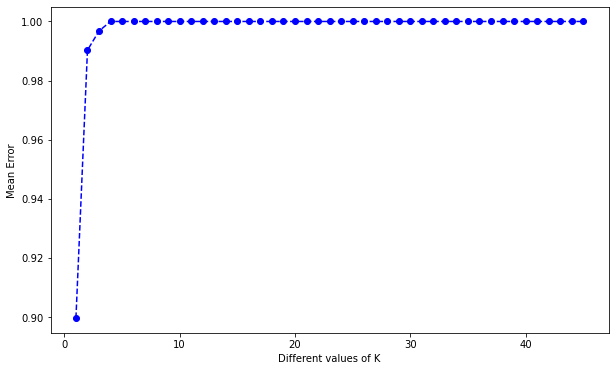

In [42]:
plt.figure(figsize=(10,6))
plt.plot(range(1,46),diff,'b--',marker='o')
plt.xlabel('Different values of K')
plt.ylabel('Mean Error')

In [43]:
model = KNeighborsRegressor(n_neighbors = 3)
model.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=3)

In [44]:
# Model Performance on Training Data
model.score(X_train,y_train)

0.904002737330544

In [45]:
# Model Performance on Testing Data
acc_k = model.score(X_test,y_test)
acc_k

0.7495205514622048

In [46]:
ypred_knn = model.predict(X_test)
metrics.mean_squared_error(y_test,ypred_knn)

65.65246666666667

In [47]:
results['Algorithm'].append('KNN Regressor')
results['Accuracy'].append(acc_k)

**KFold Cross Validation**

In [48]:
k = 20
kfold = KFold(n_splits=k)
K_result = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(K_result))
accuracy

0.6907106255855276

In [49]:
results['Algorithm'].append('KNN Regressor k-fold')
results['Accuracy'].append(accuracy)

### Bagging Regressor

In [50]:
model = BaggingRegressor()
model.fit(X_train,y_train)

BaggingRegressor()

In [51]:
# Model Performance on Training Data
model.score(X_train,y_train)

0.9767005701239972

In [52]:
# Model Performance on Testing Data
acc_ = model.score(X_test,y_test)
acc_

0.8450252911739617

In [53]:
ypred_knn = model.predict(X_test)
metrics.mean_squared_error(y_test,ypred_knn)

40.61998684831264

In [54]:
results['Algorithm'].append('Bagging Regressor')
results['Accuracy'].append(acc_)

**KFold Cross Validation**

In [55]:
k = 20
kfold = KFold(n_splits=k)
K_result = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(K_result))
accuracy

0.7297885559661558

In [56]:
results['Algorithm'].append('Bagging Regressor k-fold')
results['Accuracy'].append(accuracy)

### Support Vector Regressor

In [57]:
model = SVR()
params = {'kernel':['rbf','linear'], 'C':[1,5,10,25,50,100,200]}
grid = GridSearchCV(model, param_grid=params, cv = 5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 5, 10, 25, 50, 100, 200],
                         'kernel': ['rbf', 'linear']})

In [58]:
grid.best_estimator_

SVR(C=100)

In [59]:
model = grid.best_estimator_

In [60]:
model.fit(X_train,y_train)

SVR(C=100)

In [61]:
# Model Performance on Training Data
model.score(X_train,y_train)

0.9513682734169517

In [62]:
# Model Performance on Testing Data
acc_ = model.score(X_test,y_test)
acc_

0.8272208093737329

In [63]:
ypred_ = model.predict(X_test)
metrics.mean_squared_error(y_test,ypred_)

45.28666970285599

In [64]:
results['Algorithm'].append('SVR Regressor')
results['Accuracy'].append(acc_)

**KFold Cross Validation**

In [65]:
k = 10
kfold = KFold(n_splits=k)
K_result = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(K_result))
accuracy

0.6540051941501083

In [66]:
results['Algorithm'].append('SVR Regressor k-fold')
results['Accuracy'].append(accuracy)

### XGBoost Regressor

In [67]:
model = XGBRegressor()
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
# Model Performance on Training Data
model.score(X_train,y_train)

0.9924720060685777

In [69]:
# Model Performance on Testing Data
acc_ = model.score(X_test,y_test)
acc_

0.9019437037370225

In [70]:
ypred_ = model.predict(X_test)
metrics.mean_squared_error(y_test,ypred_)

25.701261159118754

In [71]:
results['Algorithm'].append('XGBoost Regressor')
results['Accuracy'].append(acc_)

**KFold Cross Validation**

In [72]:
k = 10
kfold = KFold(n_splits=k)
K_result = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(K_result))
accuracy

0.7014433424252026

In [73]:
results['Algorithm'].append('XGBoost Regressor k-fold')
results['Accuracy'].append(accuracy)

### Decision Tree Regressor

In [74]:
model = DecisionTreeRegressor()
model.fit(X_train,y_train)

DecisionTreeRegressor()

In [75]:
# Model Performance on Training Data
model.score(X_train,y_train)

0.9930841416603411

In [76]:
# Model Performance on Testing Data
acc_ = model.score(X_test,y_test)
acc_

0.7549837228211008

In [77]:
ypred_ = model.predict(X_test)
metrics.mean_squared_error(y_test,ypred_)

64.2205301240561

In [78]:
results['Algorithm'].append('DecisionTree Regressor')
results['Accuracy'].append(acc_)

**Feature Importance**

In [79]:
print(pd.DataFrame(100*model.feature_importances_,columns=['Importance'],index=df.columns[:-1]))

                    Importance
Cement               30.980101
Blast Furnace Slag    5.885690
Fly Ash               0.795284
Water                12.096540
Superplasticizer      4.974916
Coarse Aggregate      2.836233
Fine Aggregate        5.048358
Age                  37.382878


**KFold Cross Validation**

In [80]:
k = 20
kfold = KFold(n_splits=k)
K_result = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(K_result))
accuracy

0.5800440809470061

In [81]:
results['Algorithm'].append('DecisionTree Regressor k-fold')
results['Accuracy'].append(accuracy)

*As we have observed the features Fly Ash, Superplasticizer and Coarse Aggregate are not important*

**Feature Selection**

In [82]:
df2 = df.copy()
X = df.drop(columns=['Fly Ash', 'Superplasticizer', 'Coarse Aggregate', 'Concrete compressive strength'])
y = df['Concrete compressive strength']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [84]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
model = DecisionTreeRegressor()
model.fit(X_train,y_train)

DecisionTreeRegressor()

In [86]:
# Model Performance on Training Data
model.score(X_train,y_train)

0.9914247479910772

In [87]:
# Model Performance on Testing Data
acc_ = model.score(X_test,y_test)
acc_

0.7606982184950472

In [88]:
ypred_ = model.predict(X_test)
metrics.mean_squared_error(y_test,ypred_)

62.72271966918374

In [89]:
results['Algorithm'].append('DecisionTree 2 Regressor')
results['Accuracy'].append(acc_)

**Pruning**

In [90]:
X = df.iloc[:,:-1]
y = df['Concrete compressive strength']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [93]:
model = DecisionTreeRegressor(max_depth=4,random_state=1,min_samples_leaf=5)
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=1)

In [94]:
# Model Performance on Training Data
model.score(X_train,y_train)

0.7578225840644413

In [95]:
# Model Performance on Testing Data
acc_ = model.score(X_test,y_test)
acc_

0.556820999525816

In [96]:
ypred_ = model.predict(X_test)
metrics.mean_squared_error(y_test,ypred_)

116.16040647585388

In [97]:
results['Algorithm'].append('Pruned DecisionTree Regressor')
results['Accuracy'].append(acc_)

## Results

In [98]:
results = pd.DataFrame(results)
results.set_index('Algorithm', inplace =True)

In [99]:
results.sort_values(by='Accuracy', ascending=False )

,Accuracy
Algorithm,
XGBoost Regressor,0.901944
Gradient Boosting Regressor,0.880113
Random Forest,0.875602
Bagging Regressor,0.845025
SVR Regressor,0.827221
Gradient Boosting Regressor k-fold,0.768534
Ada Boosted Regressor,0.764714
Random Forest k-fold,0.761850
DecisionTree 2 Regressor,0.760698
